# Rare-Event Simulation for time series

## 1. the dataset and Gaussian Processes

Final negative log likelihood: 302.68505859375


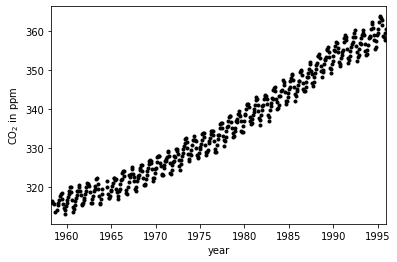

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp
import jaxopt
from tinygp import kernels, GaussianProcess

from nde import distributions, flows, transforms
import nn as nn_

import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_

from scipy.stats import norm

# jax.config.update("jax_enable_x64", True)

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]


def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)



theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
gp = build_gp(soln.params, t)

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")


Initial negative log likelihood: 392.9296875
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(3.2998936, dtype=float32), 'log_amps': DeviceArray([-56.38642  ,   1.7107545,   4.1123085,  -2.1312559], dtype=float32), 'log_diag': DeviceArray(60.331936, dtype=float32), 'log_gamma': DeviceArray(12.523522, dtype=float32), 'log_period': DeviceArray(2344.7354, dtype=float32), 'log_scales': DeviceArray([117.66017  ,  -3.104221 , -27.148645 ,  -4.0501537], dtype=float32), 'mean': DeviceArray(-0.15789795, dtype=float32)}


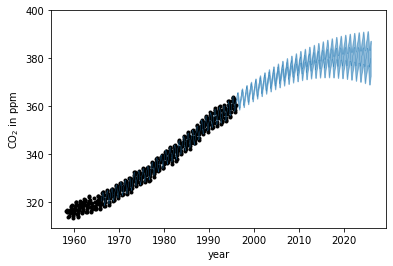

In [2]:
# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

x = np.linspace(1966, 2026, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance


plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

# plt.xlim(1980, 2025)
# plt.ylim(330, 405)
# plt.xticks(np.arange(2022, 2026, step=1)) 
# plt.yticks(np.arange(360, 410, step=10))
# plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(320, 401, step=20))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")


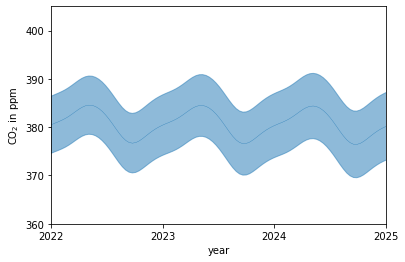

In [3]:
plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

plt.xlim(2022, 2025)
plt.ylim(360, 405)
plt.xticks(np.arange(2022, 2026, step=1)) 
plt.yticks(np.arange(360, 410, step=10))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

## 2. Experiment 1

In [3]:
num_flow_steps=2
dim=2
hidden_features=64
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=128
learning_rate = 5e-4
n_total_steps = 1e3


distribution = distributions.TweakedUniform(
    low=torch.zeros(dim),
    high=torch.ones(dim)
)

distribution = distributions.StandardNormal((2,))

def create_alternating_binary_mask(features, even=True):
    """
    Creates a binary mask of a given dimension which alternates its masking.

    :param features: Dimension of mask.
    :param even: If True, even values are assigned 1s, odd 0s. If False, vice versa.
    :return: Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

base_transform_type = 'rq'
def create_base_transform(i, _tail_bound):
    if base_transform_type == 'rq':
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            ),
            num_bins=num_bins,
            apply_unconditional_transform=False,
            tails='linear',
            tail_bound=_tail_bound,
        )
    elif base_transform_type == 'affine':
        return transforms.AffineCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            )
        )
    else:
        raise ValueError
        
## =================
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)


==run on=>  cpu


In [6]:
dd=300j
with torch.no_grad():
    _ = flow.eval()
    ddi = int(dd.imag)
    X, Y = np.mgrid[-1:1:dd, -1.1:1.1:dd]
    _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
    z = flow.log_prob(_z).exp().reshape(ddi, ddi)

In [8]:
z.min()

tensor(8.7932e-05)

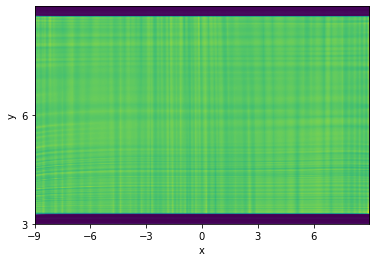

In [9]:
plt.imshow(z.T, origin='lower', extent=[-9,9,3,9], aspect="auto")
plt.xticks(np.arange(-9, 9, step=3)) 
plt.yticks(np.arange(3, 9, step=3))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

100 tensor(-0.0164) 1.57381272315979
200 tensor(-0.0016) 1.5611836910247803
300 tensor(-0.0031) 1.541959524154663
400 tensor(-0.0067) 1.5394988059997559
500 tensor(-0.0191) 1.537294864654541
600 tensor(-0.0103) 1.525344729423523
700 tensor(-0.0190) 1.524088978767395
800 tensor(0.0169) 1.5204819440841675
900 tensor(0.0038) 1.516622543334961
1000 tensor(-0.0028) 1.5135259628295898
===> tensor(-0.0028) 1.5151726007461548


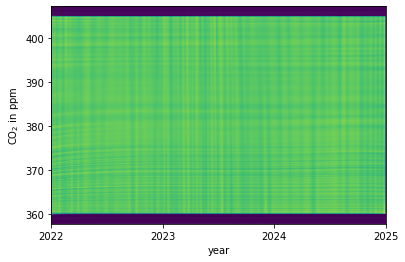

In [4]:
def plotDensity(dd=300j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, -1.1:1.1:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        # plt.figure(figsize = (20,20))
        plt.imshow(z.T, origin='lower', extent=[2022,2025,357.75,407.25], aspect="auto")
        plt.xticks(np.arange(2022, 2026, step=1)) 
        plt.yticks(np.arange(360, 410, step=10))
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()

def logf(x):
    xx = x[:,0].cpu().numpy()*1.5 + 2023.5
    cond_gp = gp.condition(y, xx).gp  ### <<<<==============
    mu, var = np.asarray(cond_gp.loc), np.asarray(cond_gp.variance)
    return -(torch.log(2*torch.pi*torch.FloatTensor(var)) + (x[:,1]*22.5 + 382.5 - mu)**2 / var )/2   \
             + torch.log(x[:,0]>-1) + torch.log(x[:,0]<1) + torch.log(x[:,1]>-1)   

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n):
    x = np.random.uniform(size=n, low =-1, high=1)
    y = np.random.uniform(size=n, low =-1, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

transform = transforms.CompositeTransform(
    [create_base_transform(i, 2) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

optimizer_servy = optim.Adam(flow.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_servy, n_total_steps)

history = []
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(2000).to(device)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    optimizer_servy.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = -torch.mean(log_prob) # calLoss(inputs, log_prob)
    loss.backward()
    optimizer_servy.step()
    scheduler.step()
    # history.append(loss.item())
print("===>", inputs[:,0].mean(), loss.item())
plotDensity()

/var/folders/kb/jnvlsd896tj2g_5wz25rg9t00000gn/T/ipykernel_48000/2609393138.py:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_numpy.cpp:178.)
  return -(torch.log(2*torch.pi*torch.FloatTensor(var)) + (x[:,1]*22.5 + 382.5 - mu)**2 / var )/2   \


100 tensor(0.0027) 0.09939534217119217
200 tensor(-0.0093) 0.09381407499313354
300 tensor(0.0259) 0.09051747620105743
400 tensor(0.0156) 0.09382389485836029
500 tensor(-0.0107) 0.08850671350955963
600 tensor(0.0350) 0.0891481563448906
700 tensor(-0.0097) 0.09130313247442245
800 tensor(0.0245) 0.08749639242887497
900 tensor(0.0303) 0.08734805136919022
1000 tensor(0.0725) 0.0885823592543602


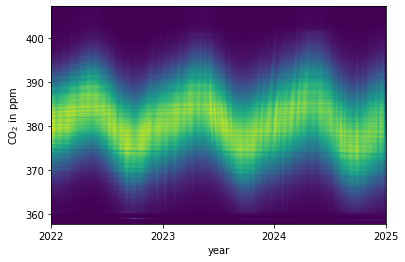

In [6]:
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1500).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotDensity()

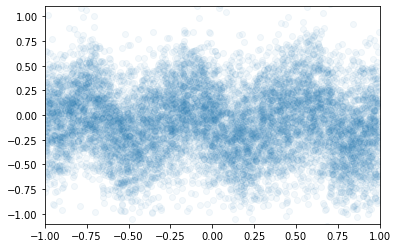

real: 3.0000000000,
mean: 2.9966986179,
 std: 0.0094154356, 
accuracy: 99.890%


In [7]:
def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([-1, 1])
            plt.ylim([-1.1, 1.1])
            plt.show()
        return intgral


v = [calIntegral(i==0, 10000)* 1.5 *22.5  for i in range(10)]  # 1.5 is x scale, 22.5 is y scale
real = 3
print("real: %.10f,\nmean: %.10f,\n std: %.10f, \naccuracy: %.3f%%" % (real, np.mean(v),
                                np.std(v), (1-np.abs(np.mean(v) - real)/real)*100))


## 3. Experiment 2 - Rare Event Simulation

100 tensor(-0.0102) 1.897200584411621
200 tensor(0.0121) 1.8722738027572632
300 tensor(-0.0151) 1.8520780801773071
400 tensor(0.0197) 1.8568652868270874
500 tensor(0.0222) 1.8508660793304443
600 tensor(0.0215) 1.8466525077819824
700 tensor(0.0026) 1.839282751083374
800 tensor(0.0223) 1.8382766246795654
900 tensor(-0.0149) 1.8357059955596924
1000 tensor(-0.0259) 1.8348238468170166
===> tensor(-0.0259) 1.8359568119049072


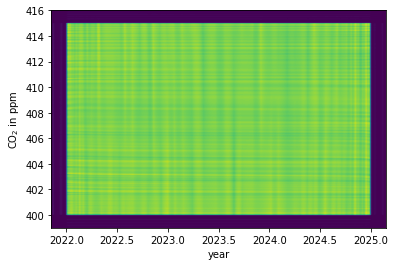

In [8]:
##==========================

def plotDensity(dd=500j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1.1:1.1:dd, -1.2:2.2:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        plt.imshow(z.T, origin='lower', extent=[2021.85,2025.15,399,416], aspect="auto")
        plt.xticks(np.arange(2022, 2026, step=1)) 
        plt.yticks(np.arange(360, 410, step=10))
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()

def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0] * 1.5 + 2023.5, x[:,1] *5 + 405

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([2022, 2025])
            plt.ylim([400, 410])
            plt.xticks(np.arange(2022, 2026, step=1)) 
            plt.yticks(np.arange(400, 415, step=5)) 
            plt.xlabel("year")
            plt.ylabel("CO$_2$ in ppm")
            plt.show()
        return intgral

def logf(x):
    xx = x[:,0].cpu().numpy()*1.5 + 2023.5
    cond_gp = gp.condition(y, xx).gp  ### <<<<==============
    mu, var = np.asarray(cond_gp.loc), np.asarray(cond_gp.variance)
    return -(torch.log(2*torch.pi*torch.FloatTensor(var)) + (x[:,1]*5 + 405 - mu)**2 / var )/2   \
             + torch.log(x[:,0]>-1) + torch.log(x[:,0]<1) + torch.log(x[:,1]>-1) 
    # return -( torch.log(torch.FloatTensor(var))   )/2   

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n):
    x = np.random.uniform(size=n, low =-1, high=1)
    y = np.random.uniform(size=n, low =-1, high=2)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))



num_flow_steps=2
dim=2
hidden_features=64
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=128
learning_rate = 5e-4
n_total_steps = 1e3

transform = transforms.CompositeTransform(
    [create_base_transform(i, 2.5) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

optimizer_servy = optim.Adam(flow.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_servy, n_total_steps)

history = []
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(2000).to(device)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    optimizer_servy.zero_grad()
    

    log_prob = flow.log_prob(inputs)
    loss = -torch.mean(log_prob) # calLoss(inputs, log_prob)
    loss.backward()
    optimizer_servy.step()
    scheduler.step()
    # history.append(loss.item())
print("===>", inputs[:,0].mean(), loss.item())
plotDensity()

100 tensor(0.0591) 0.0006096161087043583
200 tensor(0.0890) 0.00055964186321944
300 tensor(0.0812) 0.00047884901869110763
400 tensor(0.0705) 0.00045053736539557576
500 tensor(0.0755) 0.00045450267498381436
600 tensor(0.0903) 0.0004583067784551531
700 tensor(0.0660) 0.0004567012656480074
800 tensor(0.0771) 0.0004116110794711858
900 tensor(0.0791) 0.00045114982640370727
1000 tensor(0.0611) 0.0004258343833498657


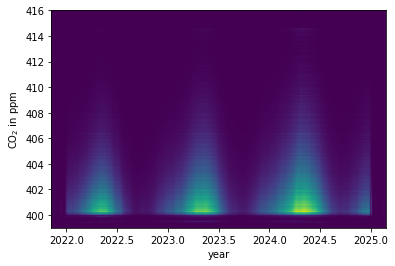

In [9]:
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1500).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotDensity()

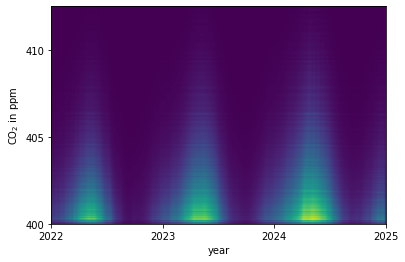

In [21]:
def plotDensity(dd=500j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, -1:1.5:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        plt.imshow(z.T, origin='lower', extent=[2022,2025,400,412.5], aspect="auto")
        plt.xticks(np.arange(2022, 2025.1, step=1)) 
        plt.yticks(np.arange(400, 412.5, step=5))
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()
plotDensity()

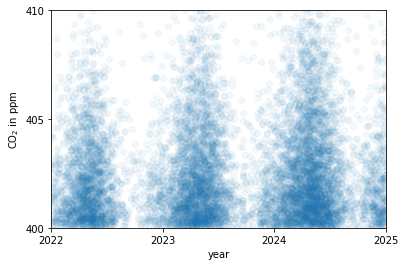


mean: 0.0024938735,
 std: 0.0000110243


In [10]:
v = [calIntegral(i==0, 10000)* 1.5 * 5 /3 for i in range(10)] # 1.5 is x scale, 5 is y scale, 3 is total area between 2022 and 2025
# real = np.mean(v)  # TODO using numerical method 
print("\nmean: %.10f,\n std: %.10f" % (np.mean(v), np.std(v)))